<h1>Import bibliotek</h1>

In [253]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, recall_score
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score

Dodam ignorowanie tych warningów bo są strasznie długie, a mówią tylko żeby zeskalować dane (co już zrobiłam) oraz że iteracji jest za mało.

In [254]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

<h1>Obserwacje na podstawie pierwszego zadania</h1>

Największe szanse na przeżycie miały (w kolejności od największego wpływu cechy):
* kobiety - przeżyło ich ok. 74% kiedy w przypadku mężczyzn było to tylko ok. 19%
* osoby znajdujące się w klasie 1 - tych przeżyło ok 63%, dla porównania osób z klasy 3 przeżyło ok 24%, a 2 - 47%
* osoby, które zapłaciły, więcej za rejs miały większe szanse na przeżycie, jednak wśrób osób, które zapłaciły mniej szanse na przeżycie i śmierć były podobne
* dzieci miały większe szanse na przeżycie, jednak szanse te bardzo szybko malały z wiekiem - dla dzieci poniżej 2 roku życia wynosiły aż 70% (pewnie dlatego, że były z matkami, które miały duże szanse na przeżycie i nie zostawiłyby swoich dzieci), dla dzieci do 10 roku życia było to już 50%, a dla dorosłych i starszych osób ok 35%

Reszta cech wykazuje bardzo małą korelację z przeżywalnością.

<h1>Przygotowanie zbioru danych</h1>

Nastąpi tu przygotowanie takie jak w zadaniu 1 tylko po podziale na zbiór trenignowy i testowy, żeby nie dopuścić do wycieku danych. (Wszystkie te rzeczy opisywałam w zadaniu 1, więc teraz okroję zbędne komentarze.)

<h3>Wczytanie zbioru:</h3>

In [255]:
titanic = pd.read_csv("titanic.csv", index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,male
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,female
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,female
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,male


<h3>Podział na cechy i etykiety:</h3>

In [256]:
y = titanic['Survived']
X = titanic.drop(['Survived'], axis=1)

<h3>Przetworzenie kolumny Cabin</h3>

Nie spowoduje wycieku, a kolumna ta wymaga zakodowanmia po przetworzeniu.

In [257]:
X.fillna({'Cabin':"N"}, inplace = True)
X['Cabin'] = X['Cabin'].apply(lambda x: x[0])

<h3>Przetworzenie kolumny Name</h3>

To co wyżej

In [258]:
X['Name'] = X['Name'].apply(lambda x: x.split(",")[1])
X['Name'] = X['Name'].apply(lambda x: x.split(" ")[1])
X['Name'] = X['Name'].apply(lambda x: x[:-1])
X['Name'] = X['Name'].apply(lambda x: x if X['Name'].value_counts().get(x, 0)>30 else 'Other')

<h3>Kodowanie zmiennych kategorycznych</h3>

Kodowanie łatwiej zrobić przed podziałem bo nie powoduje wycieku a etykiety mogłyby zostać przypisane inaczej dla zbioru testowego i treningowego.

In [259]:
X['Cabin'] = LabelEncoder().fit_transform(X.Cabin)
X['Name'] = LabelEncoder().fit_transform(X.Name)
X['Sex'] = X.Sex.map({'female': 1, 'male': 0})
X['Embarked'] = X.Embarked.map({'S': 2, 'C': 1, 'Q': 0})

<h3>Oczyszczenie</h3>

Usunięcie kolumn też nie spowoduje wycieku

In [260]:
X = X.drop(['Ticket'], axis=1)

<h3>Wstawienie dodatkowych kolumn</h3>

Nowe kolumny bazują tylko na danych wierszach, więc również nie dojdzie do wycieku a użyjemy ich potem w standaryzacji.

In [261]:
X['FamilyMembers'] = X['SibSp'] + X['Parch']
X['IsChild'] = np.where(X['Age'] >= 18, 0, 1)

<h3>Podział na zbiór testowy i treningowy:</h3>

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [263]:
X_train.head()

,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex,FamilyMembers,IsChild
PassengerId,,,,,,,,,,,
332,1,2,45.5,0,0,28.5000,2,2.0,0,0,0
734,2,2,23.0,0,0,13.0000,7,2.0,0,0,0
383,3,2,32.0,0,0,7.9250,7,2.0,0,0,0
705,3,2,26.0,1,0,7.8542,7,2.0,0,1,0
814,3,1,6.0,4,2,31.2750,7,2.0,1,6,1


In [264]:
X_test.head()

,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex,FamilyMembers,IsChild
PassengerId,,,,,,,,,,,
710,3,0,NaN,1,1,15.2458,7,1.0,0,2,1
440,2,2,31.0,0,0,10.5000,7,2.0,0,0,0
841,3,2,20.0,0,0,7.9250,7,2.0,0,0,0
721,2,1,6.0,0,1,33.0000,7,2.0,1,1,1
40,3,1,14.0,1,0,11.2417,7,1.0,1,1,1


In [277]:
y_train.value_counts()

Survived
0    444
1    268
Name: count, dtype: int64

In [278]:
y_test.value_counts()

Survived
0    105
1     74
Name: count, dtype: int64

<h3>Uzupełnienie braków:</h3>

In [265]:
x = X_train['Embarked'].mode()[0]
dict = {'Embarked':x}
X_train.fillna(dict, inplace = True)

x = X_test['Embarked'].mode()[0]
dict = {'Embarked':x}
X_test.fillna(dict, inplace = True)

In [266]:
for pclass, group in X_train.groupby('Pclass'):
    for sex, sgroup in group.groupby('Sex'):
        distribution = sgroup['Age'].value_counts(normalize=True)
        values = distribution.index
        probs = distribution.values
        age_NaN = sgroup.Age.isna()
        idx = sgroup.index[age_NaN]
        X_train.loc[idx, 'Age'] = np.random.choice(values, size=age_NaN.sum(), p=probs)
        
for pclass, group in X_test.groupby('Pclass'):
    for sex, sgroup in group.groupby('Sex'):
        distribution = sgroup['Age'].value_counts(normalize=True)
        values = distribution.index
        probs = distribution.values
        age_NaN = sgroup.Age.isna()
        idx = sgroup.index[age_NaN]
        X_test.loc[idx, 'Age'] = np.random.choice(values, size=age_NaN.sum(), p=probs)

<h3>Sprawdzenie</h3>

In [267]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 332 to 103
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         712 non-null    int64  
 1   Name           712 non-null    int32  
 2   Age            712 non-null    float64
 3   SibSp          712 non-null    int64  
 4   Parch          712 non-null    int64  
 5   Fare           712 non-null    float64
 6   Cabin          712 non-null    int32  
 7   Embarked       712 non-null    float64
 8   Sex            712 non-null    int64  
 9   FamilyMembers  712 non-null    int64  
 10  IsChild        712 non-null    int32  
dtypes: float64(3), int32(3), int64(5)
memory usage: 74.6 KB
<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 710 to 11
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         179 non-null    int64  
 1   Name           179 non-null

Działa.

<h1>Wyniki przy użyciu Dummy Classifier</h1>

Sprawdzimy jak sobie radzi kilka różnych opcji DummyClassifiera.

              precision    recall  f1-score   support

           0       0.54      0.44      0.48       105
           1       0.37      0.47      0.42        74

    accuracy                           0.45       179
   macro avg       0.46      0.46      0.45       179
weighted avg       0.47      0.45      0.46       179



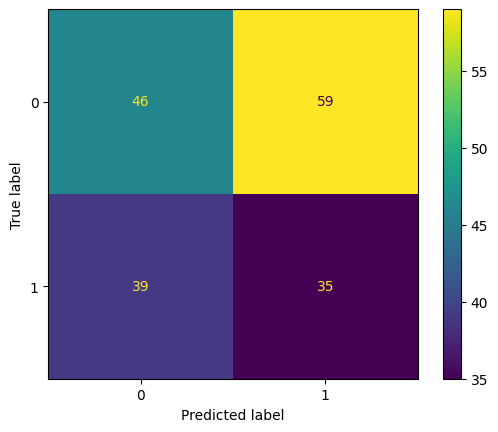

              precision    recall  f1-score   support

           0       0.57      0.64      0.60       105
           1       0.39      0.32      0.35        74

    accuracy                           0.51       179
   macro avg       0.48      0.48      0.48       179
weighted avg       0.50      0.51      0.50       179



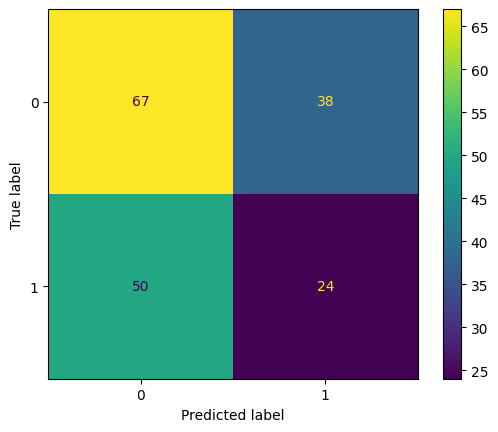

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       105
           1       0.00      0.00      0.00        74

    accuracy                           0.59       179
   macro avg       0.29      0.50      0.37       179
weighted avg       0.34      0.59      0.43       179



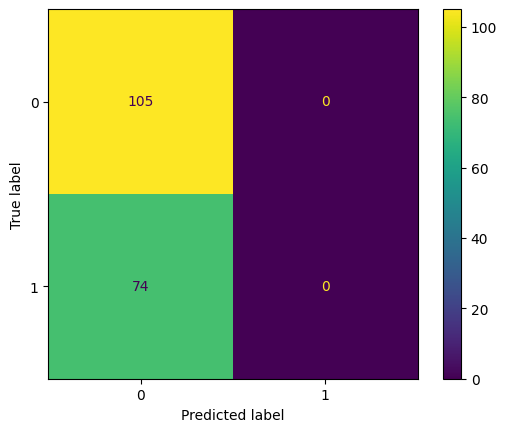

In [270]:
strategy = ['uniform', 'stratified', 'most_frequent']
#uniform - przyporządkowywanie klas z jednakowym prawdopodobieństwem
#most_frequent - zawsze zwraca bardziej prawdopodobną klasę
#stratified - przypisuje klasy zgodnie z prawdopodobieństwem

for strat in strategy:
    model = DummyClassifier(strategy = strat, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.show()

Najwyższe wyniki osiąga most_frequent za względu na duże niezbalansowanie danych.

<h1>Pierwszy model klasyfikacji - SVM</h1>

<h3>Standaryzacja</h3>

In [271]:
scaler = StandardScaler()
X_svm_train = X_train.copy()
cols_train = X_svm_train[['Age','SibSp','Parch','Fare','FamilyMembers']]
X_svm_train[['Age','SibSp','Parch','Fare','FamilyMembers']] = scaler.fit_transform(cols_train)

X_svm_test = X_test.copy()
cols_test = X_svm_test[['Age','SibSp','Parch','Fare','FamilyMembers']]
X_svm_test[['Age','SibSp','Parch','Fare','FamilyMembers']] = scaler.fit_transform(cols_test)

print(X_svm_train)
print(X_svm_test)

             Pclass  Name       Age     SibSp     Parch      Fare  Cabin  \
PassengerId                                                                
332               1     2  1.103394 -0.470722 -0.479342 -0.078684      2   
734               2     2 -0.442938 -0.470722 -0.479342 -0.377145      7   
383               3     2  0.175595 -0.470722 -0.479342 -0.474867      7   
705               3     2 -0.236761  0.379923 -0.479342 -0.476230      7   
814               3     1 -1.611278  2.931860  2.048742 -0.025249      7   
...             ...   ...       ...       ...       ...       ...    ...   
107               3     1 -0.580390 -0.470722 -0.479342 -0.480162      7   
271               1     2  1.103394 -0.470722 -0.479342 -0.030545      7   
861               3     2  0.794127  1.230569 -0.479342 -0.355804      7   
436               1     1 -1.061471  0.379923  2.048742  1.683201      1   
103               1     2 -0.580390 -0.470722  0.784700  0.860748      3   

           

Standaryzacja cech liczbowych żeby żadna nie była ważniejsza od innych - ważne dla modeli liniowych.

<h3>Zmieniane hiperparametry: kernel, max_iter</h3>

Do wyboru zbioru walidacyjnego użyjemy StrafifiedKFold bo działa dobrze dla niezbalansowanych klas i nie jest wymagający obliczeniowo.

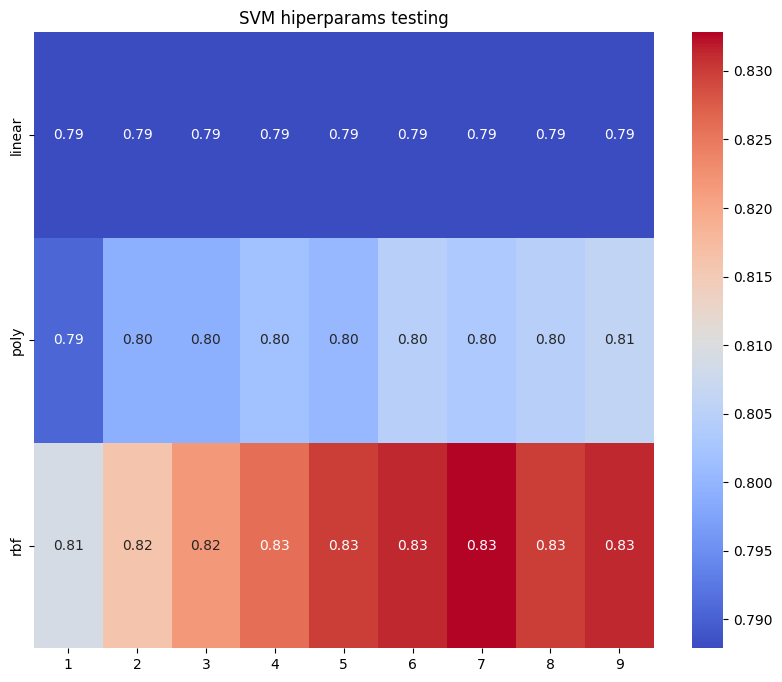

In [279]:
kernel = ['linear', 'poly', 'rbf']
C = [x for x in range(1,10)]
scores = np.zeros((len(kernel), len(C)))

for idxk, k in enumerate(kernel):
    for idxc, c in enumerate(C):
        model = SVC(kernel=k, C=c, random_state=42)
        skf = StratifiedKFold(n_splits = 5)
        scores[idxk][idxc] = cross_val_score(model, X_svm_train, y_train, cv = skf).mean()

plt.figure(figsize=(10, 8))
sns.heatmap(scores, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=C, yticklabels=kernel)
plt.title('SVM hiperparams testing')
plt.show()

<h3>SVC: kernel='rbf', C=7</h3>

Najlepsze wyniki model osiąga dla kernela=rbf i max_iter>=170, więc dla tych parametrów sprawdzimy wyniki dla zbioru testowego.

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



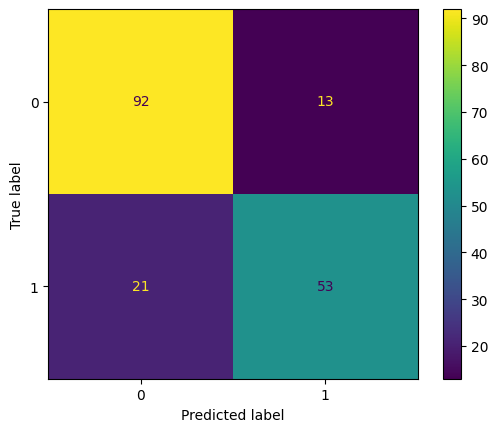

In [289]:
model = SVC(kernel='rbf', C=7, random_state=42)
model.fit(X_svm_train, y_train)
y_pred = model.predict(X_svm_test) 
print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

Model osiąga wysokie wyniki, ale sprawdzimy jak radzi sobie jeszcze 'poly' bo modele osiągają bardzo zbliżone wyniki.

<h3>SVC: kernel='poly', C=6</h3>

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       105
           1       0.73      0.84      0.78        74

    accuracy                           0.80       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.81      0.80      0.81       179



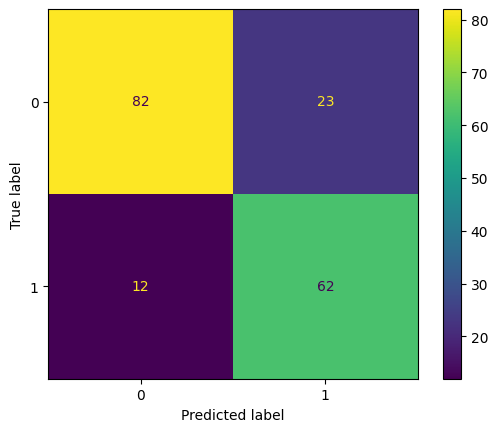

In [290]:
model = SVC(kernel='poly', C=6, random_state=42)
model.fit(X_svm_train, y_train)
y_pred = model.predict(X_svm_test) 
print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

Wyniki w sumie pokrywają się z naszymi przypuszczeniami.

<h1>Drugi model klasyfikacji - RandomForest</h1>

Dla drzew i lasów nie ma potrzeby standaryzacji cech.

<h3>Zmieniane hiperparametry: max_depth, min_samples_split</h3>

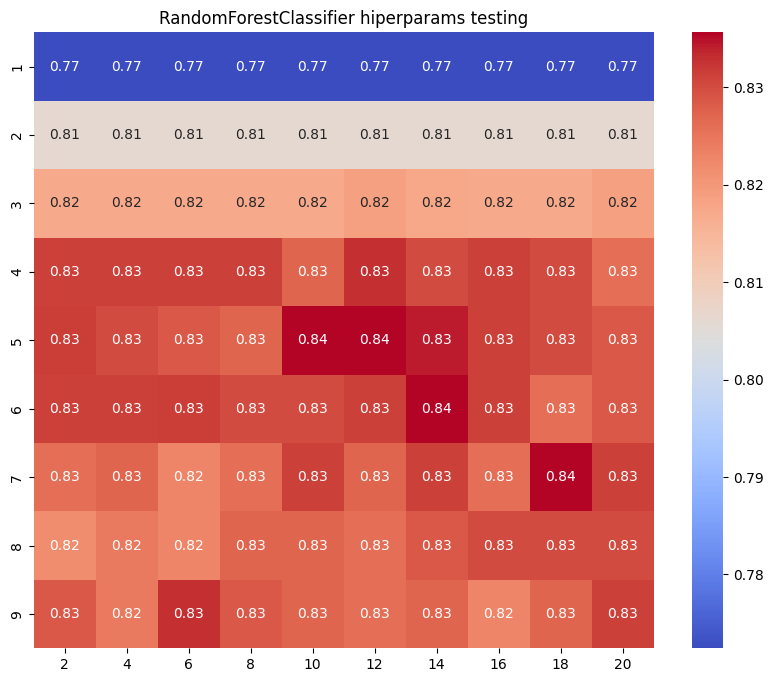

In [296]:
max_depth = [x for x in range(1,10)]
min_samples_split = [x for x in range(2,22,2)]
scores = np.zeros((len(max_depth), len(min_samples_split)))

for idxd, d in enumerate(max_depth):
    for idxs, s in enumerate(min_samples_split):
        model = RandomForestClassifier(max_depth=d, min_samples_split=s, random_state=42)
        skf = StratifiedKFold(n_splits = 5)
        scores[idxd][idxs] = cross_val_score(model, X_train, y_train, cv = skf).mean()

plt.figure(figsize=(10, 8))
sns.heatmap(scores, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=min_samples_split, yticklabels=max_depth)
plt.title('RandomForestClassifier hiperparams testing')
plt.show()

Najlepsze wyniki model osiąga dla max_depth = 18  i min_samples_split = 7, więc dla tych hiperparametrów sprawdzimy wyniki modelu dla zbioru testowego.

<h3>Forest: max_depth=18, min_samples_split=7</h3>

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       105
           1       0.83      0.77      0.80        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



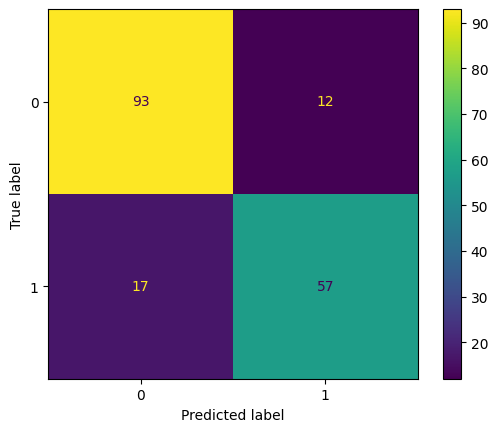

In [302]:
model = RandomForestClassifier(max_depth=18, min_samples_split=7, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

Dla porównania sprawdzimy jeszcze model i jakichś niższych parametrach i podobnym wyniku.

<h3>Forest: max_depth=12, min_samples_split=5</h3>

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       105
           1       0.83      0.77      0.80        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



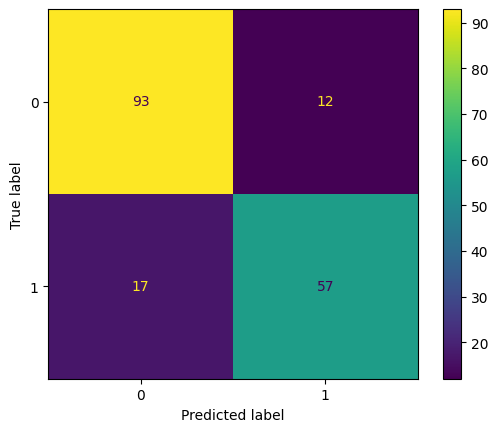

In [305]:
model = RandomForestClassifier(max_depth=12, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

Modele dla tych parametrów i tego samego random_state osiągają takie same wyniki.

<h1>Podsumowanie</h1>

1. Oba modele wypadły lepiej od modelu klasyfikującego losowo
2. Oba modele mają podobne wyniki metryk dla naszego zbioru danych, jednak RandomForest wypada minimalnie lepiej.
3. Model SVM wypada podobnie dla wszystkich testowanych hiperparametrów kernela (linear, poly i rbf)
4. Drzewo decyzyjne przy ograniczonych parametrach uzyskuje lepsze wyniki dla zbioru testowego dzięki ograniczeniu dopasowania do danych treningowych

<h1>Wnioski</h1>

1. Hiperparametry mają wpływ na dopasowanie modelu do danych treningowych - w zależności od zbioru danych, modelu i hiperparametrów wpływ ten może być różny
2. Różne modele mogą różnie się sprawdzać dla różnych zbiorow danych.
3. Na dopasowanie modelu może mieć też wpływ sposób podziału danych na zbiór treningowy i testowy - im mniej danych użyjemy do